In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
def RSS_reduction(child_L, child_R, parent):
    """
        Measures how much a spit reduces a parent node's RSS (Residual Sum of Squares)
    """
    rss_parent = sum((parent - np.mean(parent))**2)
    rss_child_L = sum((child_L - np.mean(child_L))**2)
    rss_child_R = sum((child_R - np.mean(child_R))**2)
    
    return rss_parent - (rss_child_L + rss_child_R)

def sort_x_by_y(x, y):
    unique_xs = np.unique(x)
    
    y_mean_by_x = np.array([y[x == unique_x].mean() for unique_x in unique_xs])
    ordered_xs = unique_xs[np.argsort(y_mean_by_x)]    
    
    return ordered_xs

def all_rows_equal(X):
    return (X == X[0]).all()

class Node:
    
    def __init__(self, Xsub, ysub, ID, depth=0, parent_ID=None, leaf=True):
        self.ID = ID
        self.Xsub = Xsub
        self.ysub = ysub
        self.size = len(ysub)
        self.depth = depth
        self.parent_ID = parent_ID
        self.leaf = leaf
        
class Splitter:
    
    def __init__(self):
        self.rss_reduction = 0
        self.no_split = True
        
    def _replace_split(self, rss_reduction, d, dtype='quant', t=None, L_values=None):
        self.rss_reduction = rss_reduction
        self.d = d
        self.dtype = dtype
        self.t = t
        self.L_values = L_values
        self.no_split = False

        
class DecisionTreeRegressor:
    
    """
        FITTING METHODS
    """
    def fit(self, X, y, max_depth=100, min_size=2, C=None):
        # Store data
        self.X = X
        self.y = y
        self.N, self.D = self.X.shape
        dtypes = [np.array(list(self.X[:, d])).dtype for d in range(self.D)]
        self.dtypes = ['quant' if (dtype == float or dtype == int) else 'cat' for dtype in dtypes]
            
        # Regularization parameters
        self.max_depth = max_depth
        self.min_size = min_size
        self.C = C
        
        # Initialize nodes
        self.nodes_dict = {}
        self.current_ID = 0
        initial_node = Node(Xsub=X, ysub=y, ID=self.current_ID, parent_ID=None)
        self.nodes_dict[self.current_ID] = initial_node
        self.current_ID += 1
        
        # Build tree
        self._build()
        
    def _build(self):
        
        eligible_buds = self.nodes_dict
        for layer in range(self.max_depth):
            
            # find eligible nodes for layer iteration
            eligible_buds = {
                ID: node for (ID, node) in self.nodes_dict.items() if
                                        (node.leaf == True) &
                                        (node.size >= self.min_size) &
                                        (~all_rows_equal(node.Xsub)) &
                                        (len(np.unique(node.ysub)) > 1)
            }
            
            if len(eligible_buds) == 0:
                break
                
            for ID, bud in eligible_buds.items():
                self._find_split(bud)
                if not self.splitter.no_split: # could be no split for RF
                    self._make_split()
        
    def _find_split(self, bud):
        
        splitter = Splitter()
        splitter.bud_ID = bud.ID
        
        # gather eligible predictors for Random Forests
        if self.C is None:
            eligible_predictors = np.arange(self.D)
        else:
            eligible_predictors = np.random.choice(np.arange(self.D), self.C, replace=False)
            
        for d in sorted(eligible_predictors):
            Xsub_d = bud.Xsub[:, d]
            dtype = self.dtypes[d]
            if len(np.unique(Xsub_d)) == 1:
                continue
                
            # for each threshold value
            if dtype == 'quant':
                for t in np.unique(Xsub_d)[:-1]:
                    ysub_L = bud.ysub[Xsub_d <= t]
                    ysub_R = bud.ysub[Xsub_d > t]
                    
                    rss_reduction = RSS_reduction(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction:
                        splitter._replace_split(rss_reduction, d, dtype='quant', t=t)
            else:
                ordered_x = sort_x_by_y(Xsub_d, bud.ysub)
                for i in range(len(ordered_x) - 1):
                    L_values = ordered_x[:i+1]
                    
                    ysub_L = bud.ysub[np.isin(Xsub_d, L_values)]
                    ysub_R = bud.ysub[~np.isin(Xsub_d, L_values)]
                    
                    rss_reduction = RSS_reduction(ysub_L, ysub_R, bud.ysub)
                    
                    if rss_reduction > splitter.rss_reduction:
                        splitter._replace_split(rss_reduction, d, dtype='cat', L_values=L_values)
        
        self.splitter = splitter
                        
    def _make_split(self):
        
        parent_node = self.nodes_dict[self.splitter.bud_ID]
        parent_node.leaf = False
        parent_node.child_L = self.current_ID 
        parent_node.child_R = self.current_ID + 1
        parent_node.d = self.splitter.d
        parent_node.dtype = self.splitter.dtype
        parent_node.t = self.splitter.t
        parent_node.L_values = self.splitter.L_values
        
        if parent_node.dtype == 'quant':
            L_condition = parent_node.Xsub[:, parent_node.d] <= parent_node.t
        else:
            L_condition = np.isin(parent_node.Xsub[:, parent_node.d], parent_node.L_values)
        
        Xchild_L = parent_node.Xsub[L_condition]
        ychild_L = parent_node.ysub[L_condition]
        Xchild_R = parent_node.Xsub[~L_condition]
        ychild_R = parent_node.ysub[~L_condition]
        
        child_node_L = Node(Xchild_L, ychild_L, depth=parent_node.depth+1,
                            ID=self.current_ID, parent_ID=parent_node.ID)
        
        child_node_R = Node(Xchild_R, ychild_R, depth=parent_node.depth+1,
                            ID=self.current_ID+1, parent_ID=parent_node.ID)
        
        self.nodes_dict[self.current_ID] = child_node_L
        self.nodes_dict[self.current_ID+1] = child_node_R
        self.current_ID += 2
        
    
    
    """
        PREDICTING FUNCTIONS
    """
    def _get_leaf_means(self):
        self.leaf_means = {}
        for node_ID, node in self.nodes_dict.items():
            if node.leaf:
                self.leaf_means[node_ID] = node.ysub.mean()
                
    def predict(self, X_test):
        self._get_leaf_means()
        
        yhat = []
        for x in X_test:
            node = self.nodes_dict[0]
            while not node.leaf:
                if node.dtype == 'quant':
                    if x[node.d] <= node.t:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
                else:
                    if x[node.d] in node.L_values:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
            yhat.append(self.leaf_means[node.ID])
        
        return np.array(yhat)
        

In [3]:
tips = sns.load_dataset('tips')
X = np.array(tips.drop(columns='tip'))
y = np.array(tips['tip'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, shuffle=True)

In [4]:
class RandomForest:
    
    def fit(self, X_train, y_train, B, C, max_depth=100, min_size=2, seed=None):
        
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.y_train = y_train
        self.B = B
        self.seed = seed
        self.trees = []
        
        np.random.seed(seed)
        for b in range(self.B):
            
            sample = np.random.choice(np.arange(self.N), size=self.N, replace=True)
            X_train_b = X_train[sample]
            y_train_b = y_train[sample]
            
            tree = DecisionTreeRegressor()
            tree.fit(X_train_b, y_train_b, max_depth=max_depth, min_size=min_size, C=C)
            
            self.trees.append(tree)
            
    def predict(self, X_test):
        
        y_test_hats = np.empty((len(self.trees), len(X_test)))
        for i, tree in enumerate(self.trees):
            y_test_hats[i] = tree.predict(X_test)
        
        return y_test_hats.mean(axis=0)

In [8]:
rf = RandomForest()
rf.fit(X_train, y_train, B=30, C=3, max_depth=20, min_size=5, seed=123)

y_test_hat = rf.predict(X_test)

C:\Users\wilso\Anaconda3\envs\ia-tools\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


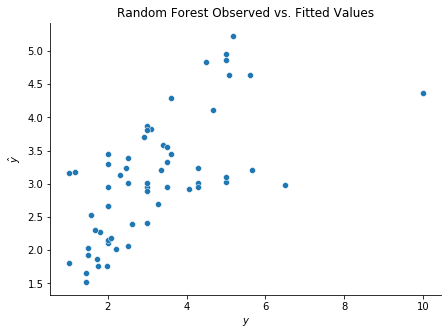

In [9]:
fig, ax = plt.subplots(figsize = (7, 5))
sns.scatterplot(y_test, y_test_hat)
ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = r'Random Forest Observed vs. Fitted Values')
sns.despine()